In [1]:
import astropy
from astropy.table import Table,  vstack
import astropy.units as u
#from astropy.io import ascii
import numpy as np
import os, sys
from os.path import expanduser
home = expanduser("~")

In [2]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
def between(lo, x, hi):
    return (lo < x) * (x < hi)

In [4]:
# not detected: mag =  99; magerr = 1-sigma upper limit assuming zero flux
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr):
    nondet = flux < 0  # Non-detection if flux is negative
    unobs = (fluxerr <= 0) + (fluxerr == np.inf)  # Unobserved if flux uncertainty is negative or infinity

    mag = flux.to(u.ABmag)
    magupperlimit = fluxerr.to(u.ABmag) # 1-sigma upper limit if flux=0

    mag = np.where(nondet, 99 * u.ABmag, mag)
    mag = np.where(unobs, -99 * u.ABmag, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux) 
    magerr = magerr.value * u.ABmag

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0 * u.ABmag, magerr)
    
    return mag, magerr

In [5]:
def extract_id(cat, id, idlabel='id'):
    # Note input id must be same format as cat[idlabel] (int or string)
    # to create an array with mostly False entries and True for id
    # cat['id'] dtype='int64'
    # cat['id'] == 3: [False, False, True, False...]
    # cat['id'] == '3': False
    #
    # obj:          astropy.table.table.Table
    # obj[0]:       astropy.table.row.Row
    # obj['id']:    astropy.table.column.Column
    # obj[0]['id']: numpy.int64
    duck_duck_goose = cat[idlabel] == int(id)
    if len(duck_duck_goose):
        obj = cat[duck_duck_goose]
    return obj[0]

In [6]:
field = 'macs0647'
#indir = '../eazy_v4'
#indir = '../catalogs'
indir  = os.path.join(home, field, 'catalogs')
infile = field + '_phot-eazy.ecsv'
infile = os.path.join(indir, infile)

catalog = astropy.io.ascii.read(infile)
catalog[:2]

id,ra,dec,x,y,z_spec,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f115w_flux,f115w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f150w_flux,f150w_fluxerr,f160w_flux,f160w_fluxerr,f200w_flux,f200w_fluxerr,f275wu_flux,f275wu_fluxerr,f277w_flux,f277w_fluxerr,f336wu_flux,f336wu_fluxerr,f356w_flux,f356w_fluxerr,f390wu_flux,f390wu_fluxerr,f435w_flux,f435w_fluxerr,f444w_flux,f444w_fluxerr,f475w_flux,f475w_fluxerr,f555w_flux,f555w_fluxerr,f606w_flux,f606w_fluxerr,f625w_flux,f625w_fluxerr,f775w_flux,f775w_fluxerr,f814w_flux,f814w_fluxerr,f850lp_flux,f850lp_fluxerr,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,energy_abs,Lu,Lj,L1400,L2800,LHa,LOIII,LHb,LOII,MLv,Av,lwAgeV,mass_p,sfr_p,Lv_p,LIR_p,energy_abs_p,Lu_p,Lj_p,L1400_p,L2800_p,LHa_p,LOIII_p,LHb_p,LOII_p,Av_p,ssfr_p,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest414,rest414_err,rest415,rest415_err,rest416,rest416_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solMass,solMass / yr,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solMass / solLum,,Gyr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,102.015220,70.161446,4098.274752800464,1.999824071826548,-1.0,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,0,-1.0,-1.0,-1.0,27082581599519.1,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000
2,101.948789,70.161459,8156.305414383205,1.9979236794378306,-1.0,-99.000,-99.000,-99.000,-99.

In [7]:
# Reconstitute filters
filters = []
for label in catalog.columns:
    if label.endswith('_flux'):
        filters.append(label[:-5])
        
#filters

In [8]:
#filters = 'f090w f115w f150w f200w f277w f356w f410m f444w'.split()

In [9]:
# flux -> mag

flux_units = u.uJy

for filt in filters:
    label = filt + '_flux'
    flux = catalog[filt+'_flux']
    fluxerr = catalog[filt+'_fluxerr']
    #flux = flux.to(u.uJy).value
    #fluxerr = fluxerr.to(u.uJy).value
    nan_flux = np.isnan(flux)
    flux = np.where(nan_flux, 0, flux)
    fluxerr = np.where(nan_flux, 1e30, fluxerr)
    mag, magerr = fluxes2mags(flux * flux_units, fluxerr * flux_units)
    #mag, magerr = fluxes2mags(flux, fluxerr)
    #cat[filt+'_flux'] = flux
    #cat[filt+'_fluxerr'] = fluxerr
    catalog[filt+'_mag'] = mag.value
    catalog[filt+'_magerr'] = magerr.value

/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


# Formulaic weights for all objects

In [10]:
mag1 = catalog['f200w_mag']
mag2 = catalog['f444w_mag']
mag = np.where(between(0, mag2, 90), mag2, mag1)
bright = (30 - mag) * between(0, mag, 90)
bright = np.clip(bright, -99, 10)
np.min(bright), np.max(bright)

(-4.9014854, 10.0)

In [11]:
z = catalog['z_phot']
z025 = catalog['z025']
highz = (z + z025) * (z < 17)
highz /= 8
np.max(highz)

4.215107

In [12]:
#faint = np.where(mag < 28, mag - 28, 0)
mag_weight = np.interp(mag, (28,30), (1,0))  # mag<28:1, mag>30:0
mag_weight = np.where(mag < 0, 0, mag_weight)

In [13]:
weight = 2.0
weight *= weight * (z > 0)  # bad photo-z's
weight *= between(0, catalog['z_phot_chi2'], 100)  # bad SED fits
weight *= 0.01 * (100 - catalog['z_phot_chi2'])  # bad SED fits
weight *= mag_weight

dust = catalog['Av']
dust = dust * (dust > 0)
weight += highz + dust #+ faint

<IPython.core.display.Javascript object>


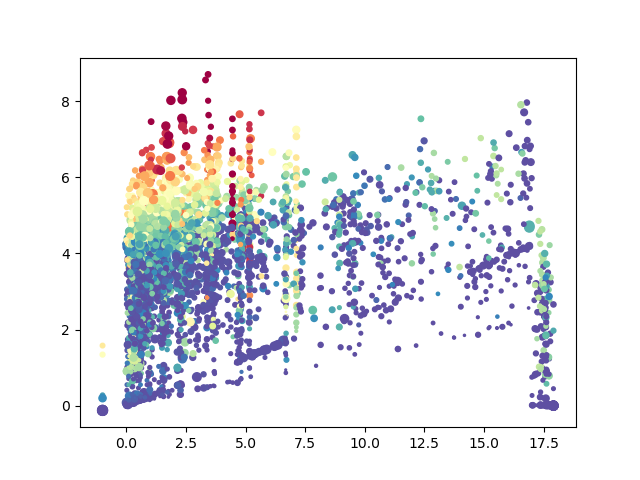

In [14]:
# with chisq weighting
s = 32 - mag
s = np.where(mag < 0, 0, s)
s = 3 * np.where(s > 0, s, 0)

fig = plt.figure()
plt.scatter(catalog['z_phot'], weight, c=catalog['Av'], s=s, vmin=0, vmax=3, cmap='Spectral_r')
#plt.ylim(32, 13)

<IPython.core.display.Javascript object>


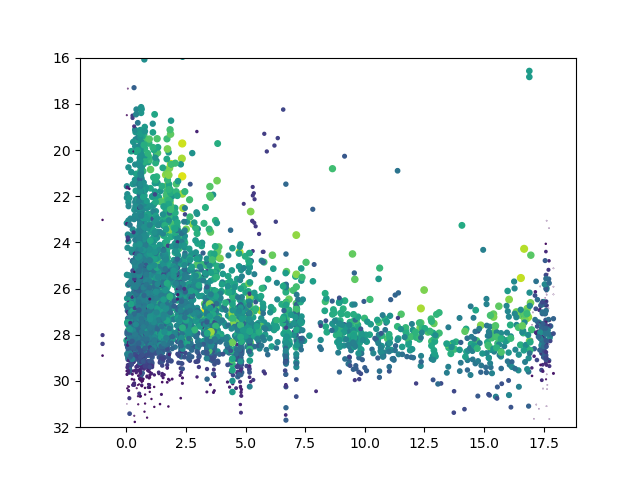

/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(32.0, 16.0)

In [15]:
fig = plt.figure()
plt.scatter(catalog['z_phot'], mag, c=weight, s=3*weight)
plt.ylim(32, 16)

In [16]:
if 0:
    z = catalog['z_phot']
    z025 = catalog['z025']
    highz = (z + z025) * (z < 17)
    dust = catalog['Av']
    dust = dust * (dust > 0)
    weight = highz + dust + bright
    weight = weight * (z > 0)
    weight = weight * between(0, catalog['z_phot_chi2'], 100)
    weight /= 4
    np.min(weight), np.max(weight)

<IPython.core.display.Javascript object>


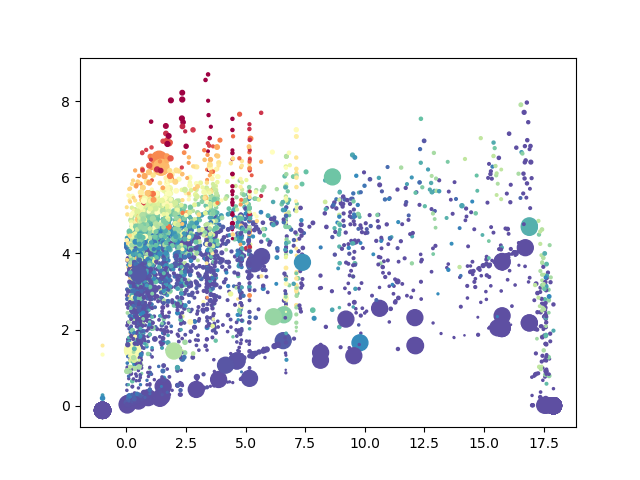

In [17]:
s = 32 - catalog['f444w_mag']
s = np.where(s > 0, s, 0)

fig = plt.figure()
plt.scatter(catalog['z_phot'], weight, c=catalog['Av'], s=s, vmin=0, vmax=3, cmap='Spectral_r')
#plt.ylim(32, 13)

In [18]:
len(catalog), catalog['id'][-1]

(5500, 5500)

In [19]:
# Forgot flux_radius
inroot = field + '-grizli-v4.0'
catalog_file = inroot + '_phot.fits.gz'
catalog_file = os.path.join(indir, catalog_file)
eazy_phot = Table.read(catalog_file)
eazy_phot[:2]
catalog['flux_radius'] = eazy_phot['flux_radius']

In [20]:
catalog['fwhm'] = 2 * catalog['flux_radius'] * 0.02

In [21]:
catalog['size'] = catalog['fwhm']

In [22]:
catalog['magnitude'] = mag

mag_err = catalog['f200w_magerr']
catalog['magnitude_error'] = magerr

In [23]:
catalog['weight'] = weight / 10.

In [24]:
catalog['reference'] = 0  # reference object? 0 or 1

In [25]:
# MACS0647 MSATA reference objects.ipynb
reference_catalog = astropy.io.ascii.read(field+'_reference_objects_nircam.ecsv')
reference_catalog[:2]

id,ra,dec,x,y,z_spec,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f115w_flux,f115w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f150w_flux,f150w_fluxerr,f160w_flux,f160w_fluxerr,f200w_flux,f200w_fluxerr,f275wu_flux,f275wu_fluxerr,f277w_flux,f277w_fluxerr,f336wu_flux,f336wu_fluxerr,f356w_flux,f356w_fluxerr,f390wu_flux,f390wu_fluxerr,f435w_flux,f435w_fluxerr,f444w_flux,f444w_fluxerr,f475w_flux,f475w_fluxerr,f555w_flux,f555w_fluxerr,f606w_flux,f606w_fluxerr,f625w_flux,f625w_fluxerr,f775w_flux,f775w_fluxerr,f814w_flux,f814w_fluxerr,f850lp_flux,f850lp_fluxerr,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,energy_abs,Lu,Lj,L1400,L2800,LHa,LOIII,LHb,LOII,MLv,Av,lwAgeV,mass_p,sfr_p,Lv_p,LIR_p,energy_abs_p,Lu_p,Lj_p,L1400_p,L2800_p,LHa_p,LOIII_p,LHb_p,LOII_p,Av_p,ssfr_p,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest414,rest414_err,rest415,rest415_err,rest416,rest416_err,flux_radius,fwhm,f105w_mag,f105w_magerr,f110w_mag,f110w_magerr,f115w_mag,f115w_magerr,f125w_mag,f125w_magerr,f140w_mag,f140w_magerr,f150w_mag,f150w_magerr,f160w_mag,f160w_magerr,f200w_mag,f200w_magerr,f275wu_mag,f275wu_magerr,f277w_mag,f277w_magerr,f336wu_mag,f336wu_magerr,f356w_mag,f356w_magerr,f390wu_mag,f390wu_magerr,f435w_mag,f435w_magerr,f444w_mag,f444w_magerr,f475w_mag,f475w_magerr,f555w_mag,f555w_magerr,f606w_mag,f606w_magerr,f625w_mag,f625w_magerr,f775w_mag,f775w_magerr,f814w_mag,f814w_magerr,f850lp_mag,f850lp_magerr,flux,peak
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solMass,solMass / yr,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solMass / solLum,,Gyr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy
int32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
3040,101.949314,70.233958,8124.999247539642,13052.279209427024,-1.0,5.427,0.023,5.558,0.018,5.454,0.026,6.171,0.024,6.144,0.015,6.436,0.022,6.265,0.020,5.511,0.016,0.001,0.024,3.226,0.010,0.006,0.019,2.742,0.009,0.029,0.012,0.085,0.013,2.123,0.008,0.171,0.011,0.343,0.008,0.643,0.024,0.819,0.021,2.499,0.027,2.966,0.011,4.460,0.032,22,5.2862883,442.005,0.00026529175,2708.3,44036.7,5.2862883,442.005,0.00026529175,5.2962255,0.00017251226,5.2962255,443.3671,5.2589,5.2784,5.2938,5.3076,5.3209,3.888,0.125,3.534,0.129,3.072,0.098,1.588,0.071,5.0e+04,9.1

In [26]:
#reference_object_ids = 4613, 1745, 816, 170, 3632, 3885, 1649, 2056, 1195, 2170, 1442, 3078, 1251, 1569, 2498, 2776, 144, 693, 733, 1673, 5697, 631, 111, 1961, 4699, 2174, 3359, 238, 2575, 5704, 1981, 2755, 3599, 3687
#reference_object_ids = 4613, 1745, 816, 170, 3710, 1901, 1621, 3632, 1026, 1084, 2341, 5606, 3885, 1649, 1740, 1045, 760, 4258, 2056, 1195, 4426, 2170, 1442, 3078, 1251, 1569, 2498, 2776, 144, 693, 3153, 433, 376, 3036, 733, 1673, 1648, 5463, 2745, 2252, 5697, 631, 5590, 4776, 111, 4908, 1961, 4699, 2174, 1540, 3359, 238, 2073, 2575, 1856, 5704, 2581, 1981, 4136, 2755, 1593, 2464, 3599, 985, 802, 3687
reference_object_ids = reference_catalog['id']
ii = np.array(reference_object_ids) - 1
catalog['reference'][ii] = 1

In [27]:
catalog['redshift'] = catalog['z_phot']

In [28]:
catalog['NRS_F110W'] = catalog['f115w_mag']
catalog['NRS_F140X'] = catalog['f150w_mag']
catalog['NRS_CLEAR'] = catalog['f200w_mag']

In [29]:
#catalog['object_type'] = 2  # general JWST catalog
catalog['object_type'] = 0  # initialize

In [30]:
len(reference_catalog), np.sum(catalog['reference'])

(36, 36)

# piXedfit catalog

some object weights may get overridden below by science catalog

In [31]:
os.getcwd()

'/Users/dcoe/macs0647/MSA/notebooks'

In [32]:
indir = os.path.join(home, field, 'catalogs')
infile = os.path.join(indir, 'catalog_pixedfit_%s.txt' % field)
piXedfit_catalog = astropy.io.ascii.read(infile, format='commented_header', header_start=-1)
catalog['weight'][piXedfit_catalog['eazy_id']-1] = 15
#catalog['weight'][piXedfit_catalog['id']-1] = 150  # if multiplying science by 10

In [33]:
#piXedfit_catalog = astropy.io.ascii.read('catalog_pixedfit_WHL0137_blank_field.cat', format='commented_header', header_start=-1)
infile = os.path.join(indir, 'catalog_pixedfit_blankfield_%s.txt' % field)
catalog['weight'][piXedfit_catalog['eazy_id']-1] = 15
#catalog['weight'][piXedfit_catalog['id']-1] = 150  # if multiplying science by 10

In [34]:
catalog['object_type'][piXedfit_catalog['eazy_id']-1] += 8  # piXedfit

In [35]:
piXedfit_catalog[:2]

pixedfit_id,eazy_id,ra,dec,z_phot,z_phot_chisq
int64,int64,float64,float64,float64,float64
1,2883,101.968846,70.229727,1.084968,4.928014
2,2920,101.981806,70.231084,2.045963,21.919733


# Jacqueline red massive / quiescent

In [36]:
# updated to remove spurious detections near bright star selfie
indir = os.path.join(home, field, 'MSA', 'catalogs')
infile = 'MACS0647-red_Jacqueline.cat'
infile = os.path.join(indir, infile)
incat = astropy.io.ascii.read(infile, format='commented_header', header_start=-1)
catalog['weight'][incat['id']-1] = incat['weight']
catalog['object_type'][incat['id']-1] += 16  # Jacqueline red

# Keduse's high-z galaxies

In [37]:
indir = os.path.join(home, field, 'MSA', 'catalogs')
infile = 'MACS0647-highz_Keduse.cat'
infile = os.path.join(indir, infile)
incat = astropy.io.ascii.read(infile, format='commented_header', header_start=-1)
catalog['weight'][incat['id']-1] = incat['weight']
catalog['object_type'][incat['id']-1] += 32  # Keduse high-z

# Rosa's bright galaxies

In [38]:
# she did the bright ones
#catalog['weight'][179-1] = 70
indir = os.path.join(home, field, 'MSA', 'catalogs')
infile = 'MACS0647-bright_Rosa.cat'
infile = os.path.join(indir, infile)
incat = astropy.io.ascii.read(infile, format='commented_header', header_start=-1)
incat[:2]
#catalog['weight'][incat['id']-1] = incat['weight']

id,real
int64,int64
2828,100
1275,100


In [39]:
catalog['weight'][incat['id']-1] *= incat['real'] / 100.  # unreal? no weight!
catalog['weight'][incat['id']-1] += incat['real'] / 100.  # boost up to +1 if real
catalog['object_type'][incat['id']-1] += 4  # Rosa bright
#catalog['object_type'] = 5

# highest weights

In [40]:
# No don't do this here! Messes up [id-1] indexing below
#catalog.sort('weight')
#catalog = catalog[::-1]
#catalog[:10]
# maybe high-z: 2318 1558 4646 4629 3301 1400 3768 5300
# xx maybe high-z: 2318 1558 4646 4629 3301 1400 3768 5300

In [41]:
#catalog['stellarity'] = 
# no stellarity in the grizli catalogs...

# High Priority Science Targets

In [42]:
infile = 'MACS0647-JD_star_arcs_z12_red1_MSA13.cat'
indir = os.path.join(home, field, 'MSA', 'catalogs')
infile = os.path.join(indir, infile)
incat = astropy.io.ascii.read(infile, format='commented_header', header_start=-1)

In [43]:
incat_ids = incat['id']
incat['id'] = np.where(incat_ids < 20000, incat_ids, incat_ids/10).astype(int)

In [44]:
catalog['weight'][incat['id']-1] = incat['weight']
catalog['object_type'][incat['id']-1] += 64  # high priority

In [45]:
catalog[4748]

id,ra,dec,x,y,z_spec,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f115w_flux,f115w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f150w_flux,f150w_fluxerr,f160w_flux,f160w_fluxerr,f200w_flux,f200w_fluxerr,f275wu_flux,f275wu_fluxerr,f277w_flux,f277w_fluxerr,f336wu_flux,f336wu_fluxerr,f356w_flux,f356w_fluxerr,f390wu_flux,f390wu_fluxerr,f435w_flux,f435w_fluxerr,f444w_flux,f444w_fluxerr,f475w_flux,f475w_fluxerr,f555w_flux,f555w_fluxerr,f606w_flux,f606w_fluxerr,f625w_flux,f625w_fluxerr,f775w_flux,f775w_fluxerr,f814w_flux,f814w_fluxerr,f850lp_flux,f850lp_fluxerr,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,energy_abs,Lu,Lj,L1400,L2800,LHa,LOIII,LHb,LOII,MLv,Av,lwAgeV,mass_p,sfr_p,Lv_p,LIR_p,energy_abs_p,Lu_p,Lj_p,L1400_p,L2800_p,LHa_p,LOIII_p,LHb_p,LOII_p,Av_p,ssfr_p,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest414,rest414_err,rest415,rest415_err,rest416,rest416_err,f105w_mag,f105w_magerr,f110w_mag,f110w_magerr,f115w_mag,f115w_magerr,f125w_mag,f125w_magerr,f140w_mag,f140w_magerr,f150w_mag,f150w_magerr,f160w_mag,f160w_magerr,f200w_mag,f200w_magerr,f275wu_mag,f275wu_magerr,f277w_mag,f277w_magerr,f336wu_mag,f336wu_magerr,f356w_mag,f356w_magerr,f390wu_mag,f390wu_magerr,f435w_mag,f435w_magerr,f444w_mag,f444w_magerr,f475w_mag,f475w_magerr,f555w_mag,f555w_magerr,f606w_mag,f606w_magerr,f625w_mag,f625w_magerr,f775w_mag,f775w_magerr,f814w_mag,f814w_magerr,f850lp_mag,f850lp_magerr,flux_radius,fwhm,size,magnitude,magnitude_error,weight,reference,redshift,NRS_F110W,NRS_F140X,NRS_CLEAR,object_type
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solMass,solMass / yr,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solMass / solLum,,Gyr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag(AB),,,,,,,
int32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float32,float64,int64,float32,float32,float32,float32,int64
4749,101.938364,70.259041,8790.3332461116,17566.90577761925,-1.0,0.011,0.013,0.018,0.010,0.024,0.006,0.024,0.013,0.049,0.007,0.028,0.005,0.047,0.012,0.030,0.004,-0.022,0.023,0.034,0.003,0.020,0.019,0.041,0.003,0.028,0.011,0.024,0.016,0.021,0.005,-0.003,0.012,0.008,0.007,0.020,0.011,0.031,0.016,0.017,0.022,0.006,0.006,0.016,0.022,22,1.0069007,28.545036,0.39184225,2708.3,44036.7,1.0069007,28.

# Highest Priority Science Targets

In [46]:
#infile = 'MACS0647-primary_MSA4.cat'
infile = 'MACS0647-primary_MSA8.cat'
indir = os.path.join(home, field, 'MSA', 'catalogs')
infile = os.path.join(indir, infile)
incat = astropy.io.ascii.read(infile, format='commented_header', header_start=-1)
incat

id,RA,DEC,fwhm,magnitude,magnitude_error,weight
int64,float64,float64,float64,float64,float64,int64
35931,101.982292,70.243269,0.05,25.1,0.02,100000
3349,101.971326,70.239716,0.05,25.6,0.026,90000
3314,101.969857,70.239389,0.05,27.7,0.103,9000
41057,102.0016,70.24945,0.05,25.0,0.027,55555
35337,101.99934,70.24244,0.05,25.515,0.03,3500


In [47]:
incat_ids = incat['id']
incat['id'] = np.where(incat_ids < 20000, incat_ids, incat_ids/10).astype(int)
incat

id,RA,DEC,fwhm,magnitude,magnitude_error,weight
int64,float64,float64,float64,float64,float64,int64
3593,101.982292,70.243269,0.05,25.1,0.02,100000
3349,101.971326,70.239716,0.05,25.6,0.026,90000
3314,101.969857,70.239389,0.05,27.7,0.103,9000
4105,102.0016,70.24945,0.05,25.0,0.027,55555
3533,101.99934,70.24244,0.05,25.515,0.03,3500


In [48]:
catalog['weight'][incat['id']-1] = incat['weight']
catalog['object_type'][incat['id']-1] += 128  # highest priority

In [49]:
#for id in 3593, 3349:  # JD1, 2 -> a
for id in incat['id']:  # shift coordinates
    inobj = extract_id(incat, id)
    catalog['ra'][id-1]  = inobj['RA']
    catalog['dec'][id-1] = inobj['DEC']

In [50]:
#i = list(science_catalog['id']).index(18888)  # interloper
#science_catalog['weight'][i] = 200  # higher than it was: 50

In [51]:
#science_catalog['weight'] *= 10  # keep lower than 1e6

# Housekeeping

In [52]:
catalog['object_type'] = np.where(catalog['object_type'], catalog['object_type'], 2)  # general JWST catalog

In [53]:
catalog.rename_column('ra', 'RA')
catalog.rename_column('dec', 'Dec')

In [54]:
#columns = 'id RA Dec redshift fwhm magnitude magnitude_error weight reference NRS_F110W NRS_F140X NRS_CLEAR'.split() # stellarity
columns = 'id RA Dec redshift fwhm magnitude magnitude_error weight reference NRS_F110W NRS_F140X NRS_CLEAR object_type'.split() # stellarity

In [55]:
output_catalog = catalog[columns]
# Make sure to keep all reference objects! Even though some will have bad SED fits and photo-z < 0
JWST_keepers = np.logical_or(output_catalog['redshift'] > 0, catalog['reference'])
output_catalog = output_catalog[JWST_keepers]
output_catalog[:2]

id,RA,Dec,redshift,fwhm,magnitude,magnitude_error,weight,reference,NRS_F110W,NRS_F140X,NRS_CLEAR,object_type
,,,,,,mag(AB),,,,,,
int32,float64,float64,float32,float64,float32,float32,float64,int64,float32,float32,float32,int64
8,101.972302,70.179500,5.1572065,0.05026431325899832,28.242014,0.0,0.6656372396558548,0,99.0,30.87799,99.0,2
9,101.968065,70.179799,0.6266081,0.13278535111547432,27.242115,0.0,0.5533122054140851,0,27.376312,27.092493,26.903244,2


In [56]:
np.sum(output_catalog['reference']), np.sum(catalog['reference'])

(36, 36)

In [57]:
#output_catalog = astropy.table.vstack([new_science_catalog, output_catalog])

In [58]:
#output_catalog = output_catalog[columns]
#output_catalog

In [59]:
output_catalog['fwhm'].info.format = '%.3f'
for label in 'magnitude magnitude_error NRS_F110W NRS_F140X NRS_CLEAR'.split():
    output_catalog[label].info.format = '%6.3f'

In [60]:
#output_catalog.write('WHL0137_full_MSA8.cat', format='ascii.commented_header', delimiter=' ', overwrite=True)
len(output_catalog)

5185

# HST catalog

In [61]:
indir = os.path.join(home, field, 'catalogs', 'Vasily')
inroot = 'macs0647_acs'
infile = inroot + '_phot_apcorr.fits'
infile = os.path.join(indir, infile)
HST_catalog = Table.read(infile)
HST_catalog[:2]

id,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2_image,y2_image,xy_image,errx2,erry2,errxy,a_image,b_image,theta_image,cxx_image,cyy_image,cxy_image,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,x_image,y_image,number,ra,dec,x_world,y_world,flux_iso,fluxerr_iso,area_iso,mag_iso,kron_radius,kron_rcirc,flux_auto,fluxerr_auto,bkg_auto,flag_auto,area_auto,flux_radius_flag,flux_radius_20,flux_radius,flux_radius_90,tot_corr,mag_auto,magerr_auto,flux_aper_0,fluxerr_aper_0,flag_aper_0,bkg_aper_0,mask_aper_0,flux_aper_1,fluxerr_aper_1,flag_aper_1,bkg_aper_1,mask_aper_1,flux_aper_2,fluxerr_aper_2,flag_aper_2,bkg_aper_2,mask_aper_2,flux_aper_3,fluxerr_aper_3,flag_aper_3,bkg_aper_3,mask_aper_3,flux_aper_4,fluxerr_aper_4,flag_aper_4,bkg_aper_4,mask_aper_4,flux_aper_5,fluxerr_aper_5,flag_aper_5,bkg_aper_5,mask_aper_5,flux_aper_6,fluxerr_aper_6,flag_aper_6,bkg_aper_6,mask_aper_6,f105w_flux_aper_0,f105w_fluxerr_aper_0,f105w_flag_aper_0,f105w_bkg_aper_0,f105w_mask_aper_0,f105w_flux_aper_1,f105w_fluxerr_aper_1,f105w_flag_aper_1,f105w_bkg_aper_1,f105w_mask_aper_1,f105w_flux_aper_2,f105w_fluxerr_aper_2,f105w_flag_aper_2,f105w_bkg_aper_2,f105w_mask_aper_2,f105w_flux_aper_3,f105w_fluxerr_aper_3,f105w_flag_aper_3,f105w_bkg_aper_3,f105w_mask_aper_3,f105w_flag_aper_4,f105w_bkg_aper_4,f105w_mask_aper_4,f105w_flag_aper_5,f105w_bkg_aper_5,f105w_mask_aper_5,f105w_flag_aper_6,f105w_bkg_aper_6,f105w_mask_aper_6,f105w_tot_corr,f110w_flux_aper_0,f110w_fluxerr_aper_0,f110w_flag_aper_0,f110w_bkg_aper_0,f110w_mask_aper_0,f110w_flux_aper_1,f110w_fluxerr_aper_1,f110w_flag_aper_1,f110w_bkg_aper_1,f110w_mask_aper_1,f110w_flux_aper_2,f110w_fluxerr_aper_2,f110w_flag_aper_2,f110w_bkg_aper_2,f110w_mask_aper_2,f110w_flux_aper_3,f110w_fluxerr_aper_3,f110w_flag_aper_3,f110w_bkg_aper_3,f110w_mask_aper_3,f110w_flag_aper_4,f110w_bkg_aper_4,f110w_mask_aper_4,f110w_flag_aper_5,f110w_bkg_aper_5,f110w_mask_aper_5,f110w_flag_aper_6,f110w_bkg_aper_6,f110w_mask_aper_6,f110w_tot_corr,f115w-clear_flux_aper_0,f115w-clear_fluxerr_aper_0,f115w-clear_flag_aper_0,f115w-clear_bkg_aper_0,f115w-clear_mask_aper_0,f115w-clear_flux_aper_1,f115w-clear_fluxerr_aper_1,f115w-clear_flag_aper_1,f115w-clear_bkg_aper_1,f115w-clear_mask_aper_1,f115w-clear_flux_aper_2,f115w-clear_fluxerr_aper_2,f115w-clear_flag_aper_2,f115w-clear_bkg_aper_2,f115w-clear_mask_aper_2,f115w-clear_flux_aper_3,f115w-clear_fluxerr_aper_3,f115w-clear_flag_aper_3,f115w-clear_bkg_aper_3,f115w-clear_mask_aper_3,f115w-clear_flag_aper_4,f115w-clear_bkg_aper_4,f115w-clear_mask_aper_4,f115w-clear_flag_aper_5,f115w-clear_bkg_aper_5,f115w-clear_mask_aper_5,f115w-clear_flag_aper_6,f115w-clear_bkg_aper_6,f115w-clear_mask_aper_6,f115w-clear_tot_corr,f125w_flux_aper_0,f125w_fluxerr_aper_0,f125w_flag_aper_0,f125w_bkg_aper_0,f125w_mask_aper_0,f125w_flux_aper_1,f125w_fluxerr_aper_1,f125w_flag_aper_1,f125w_bkg_aper_1,f125w_mask_aper_1,f125w_flux_aper_2,f125w_fluxerr_aper_2,f125w_flag_aper_2,f125w_bkg_aper_2,f125w_mask_aper_2,f125w_flux_aper_3,f125w_fluxerr_aper_3,f125w_flag_aper_3,f125w_bkg_aper_3,f125w_mask_aper_3,f125w_flag_aper_4,f125w_bkg_aper_4,f125w_mask_aper_4,f125w_flag_aper_5,f125w_bkg_aper_5,f125w_mask_aper_5,f125w_flag_aper_6,f125w_bkg_aper_6,f125w_mask_aper_6,f125w_tot_corr,f140w_flux_aper_0,f140w_fluxerr_aper_0,f140w_flag_aper_0,f140w_bkg_aper_0,f140w_mask_aper_0,f140w_flux_aper_1,f140w_fluxerr_aper_1,f140w_flag_aper_1,f140w_bkg_aper_1,f140w_mask_aper_1,f140w_flux_aper_2,f140w_fluxerr_aper_2,f140w_flag_aper_2,f140w_bkg_aper_2,f140w_mask_aper_2,f140w_flux_aper_3,f140w_fluxerr_aper_3,f140w_flag_aper_3,f140w_bkg_aper_3,f140w_mask_aper_3,f140w_flag_aper_4,f140w_bkg_aper_4,f140w_mask_aper_4,f140w_flag_aper_5,f140w_bkg_aper_5,f140w_mask_aper_5,f140w_flag_aper_6,f140w_bkg_aper_6,f140w_mask_aper_6,f140w_tot_corr,f150w-clear_flux_aper_0,f150w-clear_fluxerr_aper_0,f150w-clear_flag_aper_0,f150w-clear_bkg_aper_0,f150w-clear_mask_aper_0,f150w-clear_flux_aper_1,f150w-clear_fluxerr_aper_1,f150w-clear_flag_aper_1,f150w-clear_bkg_aper_1,f150w-c

In [62]:
indir = os.path.join(home, field, 'catalogs', 'Vasily')
inroot = 'macs_acs'
infile = inroot + '.eazypy.zout.fits'
infile = os.path.join(indir, infile)
HST_photoz = Table.read(infile)
HST_photoz[:2]

id,ra,dec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,energy_abs,Lu,Lj,L1400,L2800,LHa,LOIII,LHb,LOII,MLv,Av,lwAgeV,mass_p,sfr_p,Lv_p,LIR_p,energy_abs_p,Lu_p,Lj_p,L1400_p,L2800_p,LHa_p,LOIII_p,LHb_p,LOII_p,Av_p,ssfr_p,rest270,rest270_err,rest274,rest274_err,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest161,rest161_err,rest162,rest162_err,rest163,rest163_err,DISTMOD,ABSM_271,ABSM_272,ABSM_274
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solMass,solMass / yr,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solMass / solLum,,Gyr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64[5],float64[5],float64[5]
1,101.97552865315373,70.1614567129832,0,-1.0,-1.0,-1.0,27082581599519.1,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0,-- .. --,-- .. --,-- .. --
2,101.84149271055593,70.16142704486998,0,-1.0,-1.0,-1.0,27082581599519.1,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0,-- .. --,-- .. --,-- .. --


In [63]:
#HSTinfile = '/Users/dcoe/RELICS/data/whl0137-08/JWST/catalogs/HST/whl0137_f814w_detections.ecsv'
#HST_catalog = astropy.io.ascii.read(HSTinfile)
#HST_catalog[:2]

In [64]:
#HST_catalog.rename_column('kron_mag', 'magnitude')
#HST_catalog.rename_column('kron_magerr', 'magnitude_error')
HST_catalog.rename_column('mag_auto',    'magnitude')
HST_catalog.rename_column('magerr_auto', 'magnitude_error')

In [65]:
mag = HST_catalog['magnitude']
bright = (30 - mag) * between(0, mag, 90)
bright = np.clip(bright, -99, 10)
np.min(bright), np.max(bright)

(-2.1821974122782564, 10.0)

In [66]:
z    = HST_photoz['z_phot']
z025 = HST_photoz['z025']
highz = (z + z025) * (z < 17)
highz /= 8

In [67]:
#faint = np.where(mag < 28, mag - 28, 0)
mag_weight = np.interp(mag, (28,30), (1,0))  # mag<28:1, mag>30:0
mag_weight = np.where(mag < 0, 0, mag_weight)

In [68]:
weight = 2.0
weight *= weight * (z > 0)  # bad photo-z's
weight *= between(0,    HST_photoz['z_phot_chi2'], 100)  # bad SED fits
weight *= 0.01 * (100 - HST_photoz['z_phot_chi2'])  # bad SED fits
weight *= mag_weight

dust = HST_photoz['Av']
dust = dust * (dust > 0)
weight += highz + dust #+ faint

In [69]:
#weight /= 4
np.nanmin(weight), np.nanmax(weight)

(-0.125, 9.021950053491782)

In [70]:
weight = np.where(np.isnan(weight), 0, weight)
np.min(weight), np.max(weight)

(-0.125, 9.021950053491782)

In [71]:
weight = np.where(weight < 1, 0, weight)  # < 1 will be rounded down to 0 anyway (?)
weight = 1 + (weight - 1) / 3.  # downweight from max 9 to max 3

In [72]:
HST_catalog['fwhm'] = 2 * HST_catalog['flux_radius'] * 0.02
HST_catalog['size'] = HST_catalog['fwhm']
HST_catalog['weight'] = weight #/ 10. / 2.
HST_catalog['reference'] = 0  # reference object? 0 or 1

In [73]:
list(HST_catalog.columns)

['id',
 'thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2_image',
 'y2_image',
 'xy_image',
 'errx2',
 'erry2',
 'errxy',
 'a_image',
 'b_image',
 'theta_image',
 'cxx_image',
 'cyy_image',
 'cxy_image',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag',
 'x_image',
 'y_image',
 'number',
 'ra',
 'dec',
 'x_world',
 'y_world',
 'flux_iso',
 'fluxerr_iso',
 'area_iso',
 'mag_iso',
 'kron_radius',
 'kron_rcirc',
 'flux_auto',
 'fluxerr_auto',
 'bkg_auto',
 'flag_auto',
 'area_auto',
 'flux_radius_flag',
 'flux_radius_20',
 'flux_radius',
 'flux_radius_90',
 'tot_corr',
 'magnitude',
 'magnitude_error',
 'flux_aper_0',
 'fluxerr_aper_0',
 'flag_aper_0',
 'bkg_aper_0',
 'mask_aper_0',
 'flux_aper_1',
 'fluxerr_aper_1',
 'flag_aper_1',
 'bkg_aper_1',
 'mask_aper_1',
 'flux_aper_2',
 'fluxerr_aper_2',
 'flag_aper_2',
 'bkg_aper_2',
 'mask_aper_2',
 'flux_aper_3',
 'fluxerr_aper_3',
 'flag_aper_3',
 'bkg_aper_3',
 'mask_ape

In [74]:
#HST_catalog['redshift'] = 0.111
#HST_catalog['weight'] = 0.1  # will multiply by 10 below...
#HST_catalog['reference'] = 0
HST_catalog['NRS_F110W'] = 99 # HST_catalog['magnitude']
HST_catalog['NRS_F140X'] = 99 # HST_catalog['magnitude']
HST_catalog['NRS_CLEAR'] = 99 # HST_catalog['magnitude']

In [75]:
HST_catalog['redshift'] = HST_photoz['z_phot']
HST_catalog['object_type'] = 1  # HST catalog

# HST reference objects

In [76]:
np.sum(catalog['reference'])  # JWST starting point

36

In [77]:
# MACS0647 MSATA HST reference objects.ipynb
reference_catalog = astropy.io.ascii.read(field+'_reference_objects_hst.ecsv')
reference_catalog[:2]

id,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2_image,y2_image,xy_image,errx2,erry2,errxy,a_image,b_image,theta_image,cxx_image,cyy_image,cxy_image,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,x_image,y_image,number,ra,dec,x_world,y_world,flux_iso,fluxerr_iso,area_iso,mag_iso,kron_radius,kron_rcirc,flux_auto,fluxerr_auto,bkg_auto,flag_auto,area_auto,flux_radius_flag,flux_radius_20,flux_radius,flux_radius_90,tot_corr,mag_auto,magerr_auto,flux_aper_0,fluxerr_aper_0,flag_aper_0,bkg_aper_0,mask_aper_0,flux_aper_1,fluxerr_aper_1,flag_aper_1,bkg_aper_1,mask_aper_1,flux_aper_2,fluxerr_aper_2,flag_aper_2,bkg_aper_2,mask_aper_2,flux_aper_3,fluxerr_aper_3,flag_aper_3,bkg_aper_3,mask_aper_3,flux_aper_4,fluxerr_aper_4,flag_aper_4,bkg_aper_4,mask_aper_4,flux_aper_5,fluxerr_aper_5,flag_aper_5,bkg_aper_5,mask_aper_5,flux_aper_6,fluxerr_aper_6,flag_aper_6,bkg_aper_6,mask_aper_6,f105w_flux_aper_0,f105w_fluxerr_aper_0,f105w_flag_aper_0,f105w_bkg_aper_0,f105w_mask_aper_0,f105w_flux_aper_1,f105w_fluxerr_aper_1,f105w_flag_aper_1,f105w_bkg_aper_1,f105w_mask_aper_1,f105w_flux_aper_2,f105w_fluxerr_aper_2,f105w_flag_aper_2,f105w_bkg_aper_2,f105w_mask_aper_2,f105w_flux_aper_3,f105w_fluxerr_aper_3,f105w_flag_aper_3,f105w_bkg_aper_3,f105w_mask_aper_3,f105w_flag_aper_4,f105w_bkg_aper_4,f105w_mask_aper_4,f105w_flag_aper_5,f105w_bkg_aper_5,f105w_mask_aper_5,f105w_flag_aper_6,f105w_bkg_aper_6,f105w_mask_aper_6,f105w_tot_corr,f110w_flux_aper_0,f110w_fluxerr_aper_0,f110w_flag_aper_0,f110w_bkg_aper_0,f110w_mask_aper_0,f110w_flux_aper_1,f110w_fluxerr_aper_1,f110w_flag_aper_1,f110w_bkg_aper_1,f110w_mask_aper_1,f110w_flux_aper_2,f110w_fluxerr_aper_2,f110w_flag_aper_2,f110w_bkg_aper_2,f110w_mask_aper_2,f110w_flux_aper_3,f110w_fluxerr_aper_3,f110w_flag_aper_3,f110w_bkg_aper_3,f110w_mask_aper_3,f110w_flag_aper_4,f110w_bkg_aper_4,f110w_mask_aper_4,f110w_flag_aper_5,f110w_bkg_aper_5,f110w_mask_aper_5,f110w_flag_aper_6,f110w_bkg_aper_6,f110w_mask_aper_6,f110w_tot_corr,f115w-clear_flux_aper_0,f115w-clear_fluxerr_aper_0,f115w-clear_flag_aper_0,f115w-clear_bkg_aper_0,f115w-clear_mask_aper_0,f115w-clear_flux_aper_1,f115w-clear_fluxerr_aper_1,f115w-clear_flag_aper_1,f115w-clear_bkg_aper_1,f115w-clear_mask_aper_1,f115w-clear_flux_aper_2,f115w-clear_fluxerr_aper_2,f115w-clear_flag_aper_2,f115w-clear_bkg_aper_2,f115w-clear_mask_aper_2,f115w-clear_flux_aper_3,f115w-clear_fluxerr_aper_3,f115w-clear_flag_aper_3,f115w-clear_bkg_aper_3,f115w-clear_mask_aper_3,f115w-clear_flag_aper_4,f115w-clear_bkg_aper_4,f115w-clear_mask_aper_4,f115w-clear_flag_aper_5,f115w-clear_bkg_aper_5,f115w-clear_mask_aper_5,f115w-clear_flag_aper_6,f115w-clear_bkg_aper_6,f115w-clear_mask_aper_6,f115w-clear_tot_corr,f125w_flux_aper_0,f125w_fluxerr_aper_0,f125w_flag_aper_0,f125w_bkg_aper_0,f125w_mask_aper_0,f125w_flux_aper_1,f125w_fluxerr_aper_1,f125w_flag_aper_1,f125w_bkg_aper_1,f125w_mask_aper_1,f125w_flux_aper_2,f125w_fluxerr_aper_2,f125w_flag_aper_2,f125w_bkg_aper_2,f125w_mask_aper_2,f125w_flux_aper_3,f125w_fluxerr_aper_3,f125w_flag_aper_3,f125w_bkg_aper_3,f125w_mask_aper_3,f125w_flag_aper_4,f125w_bkg_aper_4,f125w_mask_aper_4,f125w_flag_aper_5,f125w_bkg_aper_5,f125w_mask_aper_5,f125w_flag_aper_6,f125w_bkg_aper_6,f125w_mask_aper_6,f125w_tot_corr,f140w_flux_aper_0,f140w_fluxerr_aper_0,f140w_flag_aper_0,f140w_bkg_aper_0,f140w_mask_aper_0,f140w_flux_aper_1,f140w_fluxerr_aper_1,f140w_flag_aper_1,f140w_bkg_aper_1,f140w_mask_aper_1,f140w_flux_aper_2,f140w_fluxerr_aper_2,f140w_flag_aper_2,f140w_bkg_aper_2,f140w_mask_aper_2,f140w_flux_aper_3,f140w_fluxerr_aper_3,f140w_flag_aper_3,f140w_bkg_aper_3,f140w_mask_aper_3,f140w_flag_aper_4,f140w_bkg_aper_4,f140w_mask_aper_4,f140w_flag_aper_5,f140w_bkg_aper_5,f140w_mask_aper_5,f140w_flag_aper_6,f140w_bkg_aper_6,f140w_mask_aper_6,f140w_tot_corr,f150w-clear_flux_aper_0,f150w-clear_fluxerr_aper_0,f150w-clear_flag_aper_0,f150w-clear_bkg_aper_0,f150w-clear_mask_aper_0,f150w-clear_flux_aper_1,f150w-clear_fluxerr_aper_1,f150w-clear_flag_aper_1,f150w-clear_bkg_aper_1,f150w-c

In [78]:
len(reference_catalog)

36

In [79]:
reference_object_ids = reference_catalog['id']
ii = np.array(reference_object_ids) - 1
HST_catalog['reference'][ii] = 1
#weight = HST_catalog['weight'][ii] = np.clip(HST_catalog['weight'][ii], 1, 1e6)  # make sure they make the cut

In [80]:
np.sum(HST_catalog['reference'])  # some are going to be duplicates of JWST, so don't expect all to make it in

36

In [81]:
HST_catalog['NRS_F140X'][ii] = reference_catalog['F140X_predicted']

In [82]:
HST_catalog['redshift'] = HST_photoz['z_phot']

In [83]:
HST_catalog.rename_column('ra', 'RA')
HST_catalog.rename_column('dec', 'Dec')

In [84]:
#HST_catalog['id'] = 80000 + np.arange(len(HST_catalog))

In [85]:
HST_catalog['id'] += 80000

In [86]:
#HST_catalog['id']

In [87]:
HST_catalog[:2]

id,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2_image,y2_image,xy_image,errx2,erry2,errxy,a_image,b_image,theta_image,cxx_image,cyy_image,cxy_image,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,x_image,y_image,number,RA,Dec,x_world,y_world,flux_iso,fluxerr_iso,area_iso,mag_iso,kron_radius,kron_rcirc,flux_auto,fluxerr_auto,bkg_auto,flag_auto,area_auto,flux_radius_flag,flux_radius_20,flux_radius,flux_radius_90,tot_corr,magnitude,magnitude_error,flux_aper_0,fluxerr_aper_0,flag_aper_0,bkg_aper_0,mask_aper_0,flux_aper_1,fluxerr_aper_1,flag_aper_1,bkg_aper_1,mask_aper_1,flux_aper_2,fluxerr_aper_2,flag_aper_2,bkg_aper_2,mask_aper_2,flux_aper_3,fluxerr_aper_3,flag_aper_3,bkg_aper_3,mask_aper_3,flux_aper_4,fluxerr_aper_4,flag_aper_4,bkg_aper_4,mask_aper_4,flux_aper_5,fluxerr_aper_5,flag_aper_5,bkg_aper_5,mask_aper_5,flux_aper_6,fluxerr_aper_6,flag_aper_6,bkg_aper_6,mask_aper_6,f105w_flux_aper_0,f105w_fluxerr_aper_0,f105w_flag_aper_0,f105w_bkg_aper_0,f105w_mask_aper_0,f105w_flux_aper_1,f105w_fluxerr_aper_1,f105w_flag_aper_1,f105w_bkg_aper_1,f105w_mask_aper_1,f105w_flux_aper_2,f105w_fluxerr_aper_2,f105w_flag_aper_2,f105w_bkg_aper_2,f105w_mask_aper_2,f105w_flux_aper_3,f105w_fluxerr_aper_3,f105w_flag_aper_3,f105w_bkg_aper_3,f105w_mask_aper_3,f105w_flag_aper_4,f105w_bkg_aper_4,f105w_mask_aper_4,f105w_flag_aper_5,f105w_bkg_aper_5,f105w_mask_aper_5,f105w_flag_aper_6,f105w_bkg_aper_6,f105w_mask_aper_6,f105w_tot_corr,f110w_flux_aper_0,f110w_fluxerr_aper_0,f110w_flag_aper_0,f110w_bkg_aper_0,f110w_mask_aper_0,f110w_flux_aper_1,f110w_fluxerr_aper_1,f110w_flag_aper_1,f110w_bkg_aper_1,f110w_mask_aper_1,f110w_flux_aper_2,f110w_fluxerr_aper_2,f110w_flag_aper_2,f110w_bkg_aper_2,f110w_mask_aper_2,f110w_flux_aper_3,f110w_fluxerr_aper_3,f110w_flag_aper_3,f110w_bkg_aper_3,f110w_mask_aper_3,f110w_flag_aper_4,f110w_bkg_aper_4,f110w_mask_aper_4,f110w_flag_aper_5,f110w_bkg_aper_5,f110w_mask_aper_5,f110w_flag_aper_6,f110w_bkg_aper_6,f110w_mask_aper_6,f110w_tot_corr,f115w-clear_flux_aper_0,f115w-clear_fluxerr_aper_0,f115w-clear_flag_aper_0,f115w-clear_bkg_aper_0,f115w-clear_mask_aper_0,f115w-clear_flux_aper_1,f115w-clear_fluxerr_aper_1,f115w-clear_flag_aper_1,f115w-clear_bkg_aper_1,f115w-clear_mask_aper_1,f115w-clear_flux_aper_2,f115w-clear_fluxerr_aper_2,f115w-clear_flag_aper_2,f115w-clear_bkg_aper_2,f115w-clear_mask_aper_2,f115w-clear_flux_aper_3,f115w-clear_fluxerr_aper_3,f115w-clear_flag_aper_3,f115w-clear_bkg_aper_3,f115w-clear_mask_aper_3,f115w-clear_flag_aper_4,f115w-clear_bkg_aper_4,f115w-clear_mask_aper_4,f115w-clear_flag_aper_5,f115w-clear_bkg_aper_5,f115w-clear_mask_aper_5,f115w-clear_flag_aper_6,f115w-clear_bkg_aper_6,f115w-clear_mask_aper_6,f115w-clear_tot_corr,f125w_flux_aper_0,f125w_fluxerr_aper_0,f125w_flag_aper_0,f125w_bkg_aper_0,f125w_mask_aper_0,f125w_flux_aper_1,f125w_fluxerr_aper_1,f125w_flag_aper_1,f125w_bkg_aper_1,f125w_mask_aper_1,f125w_flux_aper_2,f125w_fluxerr_aper_2,f125w_flag_aper_2,f125w_bkg_aper_2,f125w_mask_aper_2,f125w_flux_aper_3,f125w_fluxerr_aper_3,f125w_flag_aper_3,f125w_bkg_aper_3,f125w_mask_aper_3,f125w_flag_aper_4,f125w_bkg_aper_4,f125w_mask_aper_4,f125w_flag_aper_5,f125w_bkg_aper_5,f125w_mask_aper_5,f125w_flag_aper_6,f125w_bkg_aper_6,f125w_mask_aper_6,f125w_tot_corr,f140w_flux_aper_0,f140w_fluxerr_aper_0,f140w_flag_aper_0,f140w_bkg_aper_0,f140w_mask_aper_0,f140w_flux_aper_1,f140w_fluxerr_aper_1,f140w_flag_aper_1,f140w_bkg_aper_1,f140w_mask_aper_1,f140w_flux_aper_2,f140w_fluxerr_aper_2,f140w_flag_aper_2,f140w_bkg_aper_2,f140w_mask_aper_2,f140w_flux_aper_3,f140w_fluxerr_aper_3,f140w_flag_aper_3,f140w_bkg_aper_3,f140w_mask_aper_3,f140w_flag_aper_4,f140w_bkg_aper_4,f140w_mask_aper_4,f140w_flag_aper_5,f140w_bkg_aper_5,f140w_mask_aper_5,f140w_flag_aper_6,f140w_bkg_aper_6,f140w_mask_aper_6,f140w_tot_corr,f150w-clear_flux_aper_0,f150w-clear_fluxerr_aper_0,f150w-clear_flag_aper_0,f150w-clear_bkg_aper_0,f150w-clear_mask_aper_0,f150w-clear_flux_aper_1,f150w-clear_fluxerr_aper_1,f150w-clear_flag_aper_1,f150w-clear_bkg_aper_1,f1

In [88]:
from astropy.coordinates import SkyCoord

In [89]:
output_catalog_coordinates = SkyCoord(ra=output_catalog['RA']*u.deg, dec=output_catalog['Dec']*u.deg)

In [90]:
HST_distances = []
for i in range(len(HST_catalog)):
    obj_coordinates = SkyCoord(ra=HST_catalog['RA'][i]*u.deg, dec=HST_catalog['Dec'][i]*u.deg)
    distances = obj_coordinates.separation(output_catalog_coordinates)
    dist = np.min(distances).to(u.arcsec).value
    HST_distances.append(dist)

In [91]:
#HST_distances

<IPython.core.display.Javascript object>


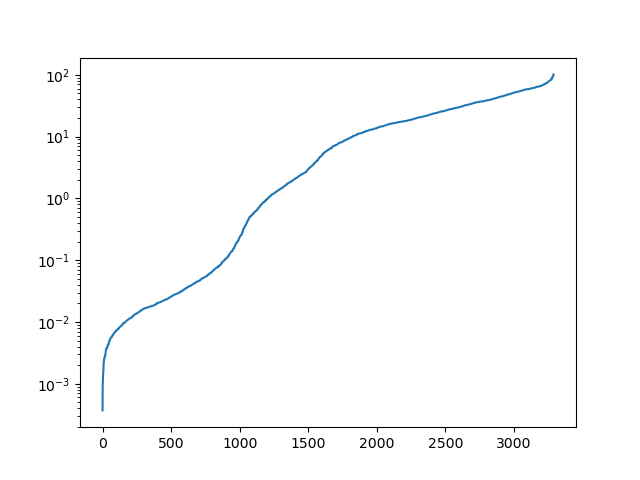

[]

In [92]:
fig = plt.figure()
plt.plot(np.sort(HST_distances))
plt.semilogy()

In [93]:
HST_only = np.array(HST_distances) > 10  # " away
add_HST_catalog = HST_catalog[HST_only]
len(add_HST_catalog), len(HST_catalog)

(1466, 3288)

In [94]:
add_HST_catalog = add_HST_catalog[columns]

In [95]:
#add_HST_catalog['fwhm']

In [96]:
#add_HST_catalog['fwhm'] *= 0.04

In [97]:
for column in columns:
    output_catalog[column]  = output_catalog[column].value
    add_HST_catalog[column] = add_HST_catalog[column].value

In [98]:
JWST_HST_output_catalog = astropy.table.vstack([output_catalog, add_HST_catalog])

In [99]:
JWST_HST_output_catalog[:2]

id,RA,Dec,redshift,fwhm,magnitude,magnitude_error,weight,reference,NRS_F110W,NRS_F140X,NRS_CLEAR,object_type
int32,float64,float64,float32,float64,float64,float64,float64,int64,float64,float64,float64,int64
8,101.97230158070401,70.17950019234193,5.1572065,0.05026431325899832,28.242013931274414,0.0,0.6656372396558548,0,99.0,30.87799072265625,99.0,2
9,101.96806520892748,70.17979906228116,0.6266081,0.13278535111547432,27.242115020751953,0.0,0.5533122054140851,0,27.376312255859375,27.092493057250977,26.903244018554688,2


In [100]:
#JWST_HST_output_catalog.write('WHL0137_full_MSA8.cat', format='ascii.commented_header', delimiter=' ', overwrite=True)
len(JWST_HST_output_catalog)

6651

<IPython.core.display.Javascript object>


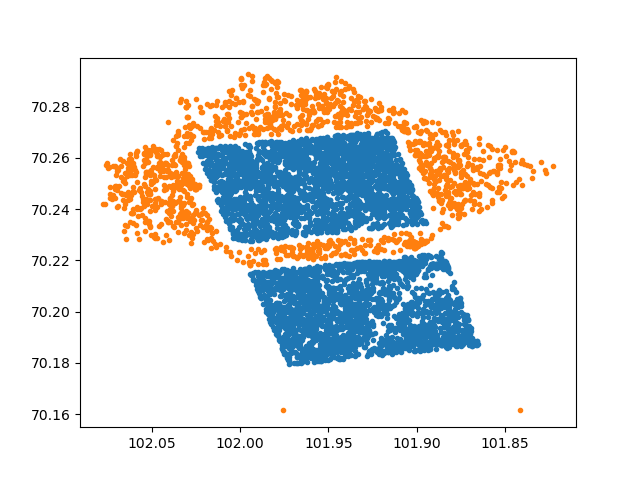

In [101]:
if 1:
    fig = plt.figure()
    plt.plot(output_catalog['RA'], output_catalog['Dec'], '.')
    plt.plot(add_HST_catalog['RA'], add_HST_catalog['Dec'], '.')
    plt.xlim(plt.xlim()[::-1])

In [102]:
#output_catalog

# Background slits near primary science targets

# Background Grid across the FOV

In [103]:
#RA1 = np.min(science_catalog['RA'])
#RA2 = np.max(science_catalog['RA'])
RA1 = np.min(JWST_HST_output_catalog['RA'])
RA2 = np.max(JWST_HST_output_catalog['RA'])
#RA1, RA2 = 24.3, 24.385  # right left

#Dec1 = np.min(science_catalog['Dec'])
#Dec2 = np.max(science_catalog['Dec'])
Dec1 = np.min(JWST_HST_output_catalog['Dec'])
Dec2 = np.max(JWST_HST_output_catalog['Dec'])

#Decgridfull, RAgridfull = np.mgrid[Dec1:Dec2:40j, RA1:RA2:30j]
Decgridfull, RAgridfull = np.mgrid[Dec1:Dec2:40j, RA1:RA2:40j]

# But not too dense, or you'll overwhelm the search and miss your primary targets!
#Decgridfull, RAgridfull = np.mgrid[Dec1:Dec2:80j, RA1:RA2:80j]  # needs to be dense to have a shot at slits
#Decgridfull, RAgridfull = np.mgrid[Dec1:Dec2:150j, RA1:RA2:150j]  # needs to be dense to have a shot at slits

<IPython.core.display.Javascript object>


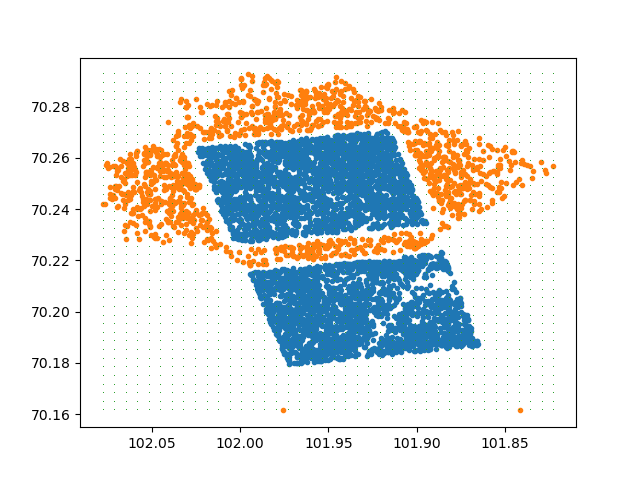

(102.09047230955422, 101.80991379610006)

In [104]:
fig = plt.figure()
plt.plot(output_catalog['RA'],  output_catalog['Dec'],  '.')
plt.plot(add_HST_catalog['RA'], add_HST_catalog['Dec'], '.')

#plt.plot(background_catalog['RA'], background_catalog['Dec'], '.')
plt.plot(RAgridfull.flat, Decgridfull.flat, ',')

plt.xlim(plt.xlim()[::-1])

#plt.semilogy()

In [105]:
# not on segments; whatever let them fall where they will and we'll get a few galaxies

In [106]:
n = len(Decgridfull.flat)
n

1600

In [107]:
background_grid = Table()
background_grid['RA']  = RAgridfull.flat
background_grid['Dec'] = Decgridfull.flat
background_grid['id'] = 50000 + np.arange(n)  # 30000 would clobber JD

In [108]:
#background_grid['weight'] = 5
#version = 1

background_grid['weight'] = 1
version = 2

# Maybe it needs better numbers to work properly
background_grid['redshift'] = 67
background_grid['fwhm'] = 1
background_grid['magnitude'] = 28
background_grid['magnitude_error'] = 0.3
background_grid['reference'] = 0
background_grid['NRS_F110W'] = 28
background_grid['NRS_F140X'] = 28
background_grid['NRS_CLEAR'] = 28

background_grid['object_type'] = 0

In [109]:
#JWST_HST_background2_output_catalog = astropy.table.vstack([JWST_HST_background_output_catalog, background_grid])
JWST_HST_background_output_catalog = astropy.table.vstack([JWST_HST_output_catalog, background_grid])

In [110]:
JWST_HST_background_output_catalog.sort('weight', reverse=True)

In [111]:
nothing = np.isnan(JWST_HST_background_output_catalog['weight'])
#nothing = JWST_HST_background_output_catalog['weight'].mask
JWST_HST_background_output_catalog = JWST_HST_background_output_catalog[np.logical_not(nothing)]

In [112]:
JWST_HST_background_output_catalog[:10]

id,RA,Dec,redshift,fwhm,magnitude,magnitude_error,weight,reference,NRS_F110W,NRS_F140X,NRS_CLEAR,object_type
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64
3593,101.982292,70.243269,10.62480354309082,0.19919549244881882,25.110395431518555,27.589405059814453,100000.0,0,99.0,25.142562866210938,24.988525390625,196
3349,101.971326,70.239716,10.580673217773438,0.1798625745608515,25.580730438232422,27.704788208007812,90000.0,0,99.0,25.753679275512695,25.47004508972168,192
4105,102.0016,70.24945,4.926225662231445,0.36685800408243346,25.109397888183594,1.1451958417892456,55555.0,0,25.59362030029297,25.807313919067383,25.579755783081055,208
4871,101.9811153111661,70.26059028804619,10.217918395996094,0.1250784394379341,26.46900177001953,0.7702993154525757,50000.0,0,99.0,26.47178840637207,26.233205795288086,64
3621,101.98280314525128,70.24386546347031,0.5222406983375549,0.13902577392489934,27.826091766357422,27.69484519958496,10000.0,0,29.909727096557617,28.174476623535156,28.054401397705078,64
3314,101.969857,70.239389,9.125478744506836,0.1032258750132938,27.886154174804688,27.979116439819336,9000.0,0,28.34926986694336,27.347003936767578,27.35410499572754,224
4077,102.00246374930899,70.250223915208,3.3844432830810547,0.1446616831258076,27.007678985595703,27.93605613708496,4500.0,0,27.258899688720703,27.570955276489258,26.32850456237793,80
3533,101.99934,70.24244,11.409835815429688,0.18019927728282023,26.186561584472656,0.44672590494155884,3500.0,0,27.133663177490234,26.408979415893555,25.513076782226562,224
4858,101.98050557476255,70.26044756831507,10.618003845214844,0.08488502836262368,29.573253631591797,27.85312271118164,3000.0,0,99.0,28.438358306884766,27.817123413085938,64


In [113]:
# for output file name
version = 3  # fixed JD id bug and updated RA,Dec to JD1a, JD2a
version = 4  # formatting to fewer significant digits
version = 5  # reference objects all have weight = 1 (most had 0 before)

version = 8  # repeat Obs23; primary catalog tweaks; HST reference objects overhauled
version = 82  # updated weights; added object_type; updated HST reference objects again; denser background grid
version = 83  # medium background grid
version = 84  # original background grid
version = 85  # bug fix: highest priority targets bumped!
version = 86  # bug fix: removed objects near star selfie in Jacqueline's red catalog
version = 87  # updated JWST reference stars: no magnitude cut! (until faint, also smaller fwhm's)
version = 88  # JWST reference stars weren't all kept in catalog! fixed this notebook
version = 89  # JWST reference stars a bit broader to fwhm 0.15" (but did 0.11" - 0.15" by mistake)
version = '8a'  # JWST reference stars a bit broader to fwhm 0.15"
version = '8b'  # JWST reference stars a bit broader to fwhm 0.17"
version = '8c'  # reference stars weight = 0 (see if that improves things??)
version = '8d'  # randomize IDs so it doesn't just pick low numbers in one quadrant
version = '8e'  # actually do these things (last times, those lines were after saving the catalog!)
version = '8f'  # less is more: compact and within brightness range
version = '8g'  # less is more: fwhm 0.15" and within brightness range; also fixed IDs and not random

In [114]:
JWST_HST_background_output_catalog['fwhm'].info.format = '%.3f'

for label in 'redshift magnitude magnitude_error NRS_F110W NRS_F140X NRS_CLEAR'.split():
    JWST_HST_background_output_catalog[label].info.format = '%6.3f'

for label in 'RA Dec'.split():
    JWST_HST_background_output_catalog[label].info.format = '%10.6f'
    
for label in 'id weight reference'.split():
    JWST_HST_background_output_catalog[label].info.format = '%d'


In [115]:
#JWST_HST_background_output_catalog.write('MACS0647_full_MSA%d.cat' % version, format='ascii.commented_header', delimiter=' ') #, overwrite=True)
JWST_HST_background_output_catalog.write('MACS0647_full_MSA%s.cat' % version, format='ascii.commented_header', delimiter=' ') #, overwrite=True)
len(JWST_HST_background_output_catalog)

8251

In [116]:
np.sum(JWST_HST_background_output_catalog['reference'])

49

In [117]:
np.sum(catalog['reference'])

36

In [118]:
# Make sure reference objects make the cut
reference_subset = JWST_HST_background_output_catalog['reference'] == True
weight = JWST_HST_background_output_catalog['weight'][reference_subset] + 0
JWST_HST_background_output_catalog['weight'][reference_subset] = np.clip(weight, 1, 1e6)
#JWST_HST_background_output_catalog['weight'][reference_subset]

In [134]:
weight1 = JWST_HST_background_output_catalog['weight'] > 0.99
weight1_catalog = JWST_HST_background_output_catalog[weight1]

In [135]:
# Didn't work; Randomize the IDs so you don't just get low IDs at top left
#n = len(weight1_catalog)
#weight1_catalog['id'] += np.random.choice((60000,70000),n)
#weight1_catalog['id'] += 60000 * np.ones(n).astype(int)
#reference_subset = weight1_catalog['reference'] == True
#weight = weight1_catalog['weight'][reference_subset] + 0
#ids = weight1_catalog['id'][reference_subset] + 0
#weight1_catalog['id'][reference_subset] += 60000

In [136]:
ids = weight1_catalog['id']
ids2 = np.where(weight1_catalog['reference'], ids+60000, ids)
ids3 = np.where(weight1_catalog['reference'], ids+10000, ids)
ids = np.where(ids < 10000, ids2, ids3)
weight1_catalog['id'] = ids

In [137]:
# Now set the weights to zero so you don't get spectra of them
weight1_catalog['weight'] *= 1 - weight1_catalog['reference']

In [138]:
weight1_catalog[:5]

id,RA,Dec,redshift,fwhm,magnitude,magnitude_error,weight,reference,NRS_F110W,NRS_F140X,NRS_CLEAR,object_type
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64
3593,101.982292,70.243269,10.625,0.199,25.110,27.589,100000,0,99.000,25.143,24.989,196
3349,101.971326,70.239716,10.581,0.180,25.581,27.705,90000,0,99.000,25.754,25.470,192
4105,102.001600,70.249450,4.926,0.367,25.109,1.145,55555,0,25.594,25.807,25.580,208
4871,101.981115,70.260590,10.218,0.125,26.469,0.770,50000,0,99.000,26.472,26.233,64
3621,101.982803,70.243865,0.522,0.139,27.826,27.695,10000,0,29.910,28.174,28.054,64


In [140]:
weight1_catalog.write('MACS0647_weight1_MSA%s.cat' % version, format='ascii.commented_header', delimiter=' ') #, overwrite=True
weight1_catalog.write('MACS0647_weight1_MSA%s.txt' % version, format='ascii.fixed_width_two_line', delimiter=' ') #, overwrite=True
len(weight1_catalog)

3297

In [141]:
#weight1_catalog.write('test.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [142]:
np.sum(weight1_catalog['reference'])

49

In [143]:
np.sum(JWST_HST_background_output_catalog['reference'])

49

In [144]:
#JWST_HST_background_output_catalog['weight'] *= 1 - JWST_HST_background_output_catalog['reference']

In [145]:
#n = len(JWST_HST_background_output_catalog)
#JWST_HST_background_output_catalog['id'] += np.random.choice((60000,70000),n)

In [146]:
#JWST_HST_background_output_catalog[JWST_HST_background_output_catalog['reference'] == True]

In [147]:
weight1_catalog[weight1_catalog['reference'] == True]

id,RA,Dec,redshift,fwhm,magnitude,magnitude_error,weight,reference,NRS_F110W,NRS_F140X,NRS_CLEAR,object_type
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64
65127,101.955059,70.263555,5.753,0.086,24.407,0.031,0,1,23.613,23.451,23.523,20
63248,101.956596,70.238030,0.615,0.143,22.741,0.014,0,1,22.671,22.282,22.051,8
92587,102.036231,70.264470,2.934,0.080,26.222,0.005,0,1,99.000,22.000,99.000,1
92789,101.883518,70.268871,3.504,0.075,26.585,0.011,0,1,99.000,23.000,99.000,1
93256,101.998680,70.287356,3.302,0.067,28.333,0.052,0,1,99.000,24.000,99.000,1
93051,102.007316,70.277205,0.815,0.083,26.470,0.010,0,1,99.000,22.000,99.000,1
92967,101.946897,70.274003,2.989,0.074,26.975,0.008,0,1,99.000,23.000,99.000,1
92071,101.866007,70.256427,0.250,0.076,25.708,0.005,0,1,99.000,22.000,99.000,1
92962,101.944794,70.273403,0.505,0.083,26.424,0.005,0,1,99.000,23.000,99.000,1


In [132]:
set(JWST_HST_background_output_catalog['object_type'])

{0,
 1,
 2,
 4,
 8,
 12,
 16,
 20,
 24,
 28,
 32,
 36,
 48,
 52,
 64,
 68,
 72,
 76,
 80,
 84,
 96,
 112,
 192,
 196,
 208,
 224}

In [133]:
128 + 64

192